In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import important libraries

In [2]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import dill
from sklearn.utils import shuffle

# Read train data

In [4]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed_under')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed_under')['target_event']

# Load test pipline

In [5]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as f:
    test_pipeline = dill.load(f)

# Read test data and transform


In [6]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')['target_event']

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

In [8]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy

    def classification_report(self):
        report = classification_report(self.y_test, self.y_pred)
        return report

    def precision_recall_f1(self):
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        return precision, recall, f1
    def roc_score(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        return auc_score

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_visualization(self):
        auc_score = self.roc_score()
        print('=========================')
        print('||','ROC AUC Score:', auc_score.round(2),'||')
        print('=========================')
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_curve_plot(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

---
# ***AdaBoost Classifier Model***
---

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Initialize AdaBoost Classifier

In [ ]:
ada_boost = AdaBoostClassifier(
    estimator=LogisticRegression(),
    algorithm='SAMME',
    random_state=42
)

# Initialize Stratifiedkfold

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Using grid search find best parameters and best splits using stratifiedkfold

In [ ]:
params = {
    'n_estimators': [50, 55, 60],
    'learning_rate': [0.5, 0.7]
}

ada_search = GridSearchCV(
    estimator=ada_boost,
    param_grid=params,
    cv = kfold,
    scoring='f1',
    n_jobs=2
)

In [ ]:
ada_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=LogisticRegression(),
                                          random_state=42),
             n_jobs=2,
             param_grid={'learning_rate': [0.5, 0.7],
                         'n_estimators': [50, 55, 60]},
             scoring='f1')

In [ ]:
best_params = ada_search.best_params_
best_score = ada_search.best_score_

In [ ]:
print('Best Parameters:', best_params)
print('Best Score:', best_score)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 55}
Best Score: 0.7864839557396442


# Create adaboost classifier evaluation object

In [ ]:
ada_eval = BinaryClassificationEvaluation(y_test, ada_search.predict(X_test), ada_search.predict_proba(X_test)[:, 1])

# Evaluate model from different corner

In [ ]:
print(ada_eval.classification_report())

              precision    recall  f1-score   support

           0       0.89      0.81      0.84     15296
           1       0.66      0.78      0.71      7226

    accuracy                           0.80     22522
   macro avg       0.77      0.79      0.78     22522
weighted avg       0.81      0.80      0.80     22522



In [ ]:
precision, recall, f1 = ada_eval.precision_recall_f1()
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.6557129586623316
Recall: 0.7814835316911154
F1 Score: 0.7130950877636065


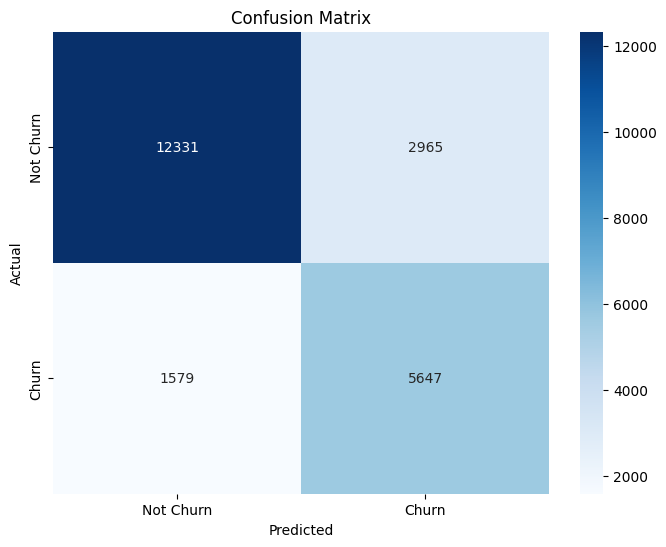

In [ ]:
ada_eval.visualize_confusion_matrix()

|| ROC AUC Score: 0.87 ||


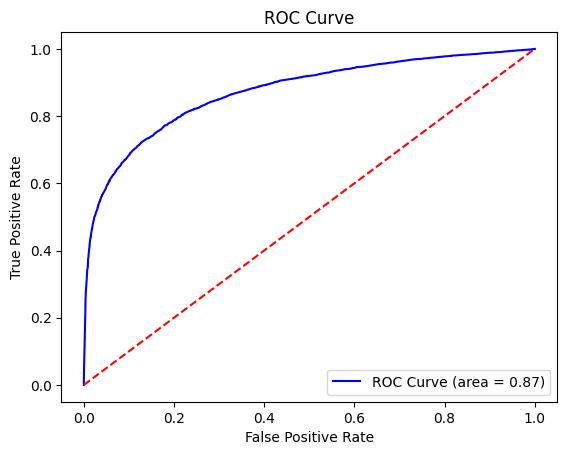

In [ ]:
ada_eval.roc_curve_visualization()

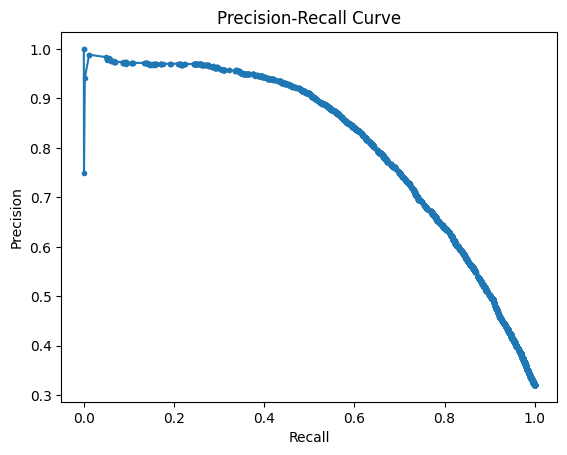

In [ ]:
ada_eval.precision_recall_curve_plot()

# Try performance in different threshold

In [ ]:
ada_theshold = 0.65
ada_y_pred = np.where(ada_search.predict_proba(X_test)[:, 1] >= ada_theshold, 1, 0)

In [ ]:
ada_thesh_eval = BinaryClassificationEvaluation(y_test, ada_y_pred, ada_search.predict_proba(X_test)[:, 1])

In [ ]:
print(ada_thesh_eval.classification_report())

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     15296
           1       0.82      0.62      0.71      7226

    accuracy                           0.84     22522
   macro avg       0.83      0.78      0.80     22522
weighted avg       0.83      0.84      0.83     22522



---
# ***XGBoost Classifier Model***
---

In [9]:
!pip install xgboost

In [10]:
import xgboost as xgb
import os

# Create XGBoost model class

In [161]:
class XGBoostTrain:
    def __init__(self, max_depth, subsample, colsample_bytree, learning_rate, num_boost_round, metric='auc'):
        self.model = None
        self.max_depth = max_depth
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.learning_rate = learning_rate
        self.metric = metric
        self.num_boost_round = num_boost_round

        self.params = {
            'max_depth': self.max_depth,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'learning_rate': self.learning_rate,
            'eval_metric': [metric, 'logloss']
        }
        self.result = {}

    def to_matrix(self, X, y):
        return xgb.DMatrix(X, label=y)

    def early_stopping(self, rounds=30, metric='auc', data_name='test', save_best=True):
        return xgb.callback.EarlyStopping(
            rounds=rounds,
            metric_name=metric,
            data_name=data_name,
            save_best=save_best
        )

    def custom_learning_rate(self, current_iter):
        return self.learning_rate * (1 - (current_iter / 1000))

    def save_previous_state(self, model, evals_log, epoch):
        directory = '/content/drive/MyDrive/Churn Prediction/checkpoints'
        os.makedirs(directory, exist_ok=True)

        current_metric_value = evals_log['test'][self.metric][-1]
        model_directory = os.path.join(directory, f'{current_metric_value:.4f}_testOUC')
        os.makedirs(model_directory, exist_ok=True)

        dill.dump(model, open(os.path.join(model_directory, 'previous_model.pkl'), 'wb'))
        dill.dump(evals_log, open(os.path.join(model_directory, 'previous_evals_log.pkl'), 'wb'))

    def checkpoint(self):
        class CheckpointCallback(xgb.callback.TrainingCallback):
            def __init__(self, model_instance):
                super().__init__()
                self.model_instance = model_instance

            def after_iteration(self, model, epoch, evals_log):
                self.model_instance.save_previous_state(model, evals_log, epoch)
        return CheckpointCallback(self)

    def train(self, X_train, y_train, X_test, y_test):
        train = self.to_matrix(X_train, y_train)
        test = self.to_matrix(X_test, y_test)

        params_ = self.params.copy()
        print("Training with the following parameters:")
        params_['num_boost_round'] = self.num_boost_round
        for param, value in params_.items():
            print(f"{param}: {value}")

        early_stop = self.early_stopping()
        lr_schedule = xgb.callback.LearningRateScheduler(self.custom_learning_rate)
        checkpoint = self.checkpoint()

        callbacks = [early_stop, lr_schedule, checkpoint]

        self.model = xgb.train(
            self.params,
            train,
            evals=[(train, 'train'), (test, 'test')],
            evals_result=self.result,
            num_boost_round=self.num_boost_round,
            callbacks=callbacks,
            verbose_eval=1
        )

# Manual grid search

In [162]:
class GridSearch:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.best_model = None
        self.best_result = None
        self.best_params = None
    def gridsearch(self, params):
        for max_depth in params['max_depth']:
            for subsample in params['subsample']:
                for colsample_bytree in params['colsample_bytree']:
                    for learning_rate in params['learning_rate']:
                        for num_boost_round in params['num_boost_round']:
                            train_model = XGBoostTrain(max_depth, subsample, colsample_bytree, learning_rate, num_boost_round=num_boost_round)
                            train_model.train(self.X_train, self.y_train, self.X_test, self.y_test)

# Define search parameters

In [163]:
params = {
    'max_depth': [3, 5, 7],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_boost_round': [100, 150, 200]
}

# Define gridsearch object

In [164]:
grid_search = GridSearch(X_train, y_train, X_test, y_test)

In [166]:
grid_search.gridsearch(params)

Streaming output truncated to the last 5000 lines.
[104]	train-auc:0.84189	train-logloss:0.55408	test-auc:0.84295	test-logloss:0.55104
[105]	train-auc:0.84205	train-logloss:0.55336	test-auc:0.84308	test-logloss:0.55028
[106]	train-auc:0.84203	train-logloss:0.55269	test-auc:0.84306	test-logloss:0.54958
[107]	train-auc:0.84222	train-logloss:0.55194	test-auc:0.84320	test-logloss:0.54881
[108]	train-auc:0.84240	train-logloss:0.55120	test-auc:0.84335	test-logloss:0.54803
[109]	train-auc:0.84252	train-logloss:0.55049	test-auc:0.84349	test-logloss:0.54728
[110]	train-auc:0.84271	train-logloss:0.54982	test-auc:0.84364	test-logloss:0.54659
[111]	train-auc:0.84281	train-logloss:0.54920	test-auc:0.84370	test-logloss:0.54593
[112]	train-auc:0.84280	train-logloss:0.54850	test-auc:0.84370	test-logloss:0.54522
[113]	train-auc:0.84285	train-logloss:0.54783	test-auc:0.84378	test-logloss:0.54449
[114]	train-auc:0.84298	train-logloss:0.54723	test-auc:0.84388	test-logloss:0.54388
[115]	train-auc:0.84317	t

In [169]:
import re

In [170]:
def find_best_model(self):
    directory = '/content/drive/MyDrive/Churn Prediction/checkpoints'
    highest_folder = None
    highest_value = -1

    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            match = re.search(r'(\d+(\.\d+)?)', folder)
            if match:
                value = float(match.group(0))
                if value > highest_value:
                    highest_value = value
                    highest_folder = folder_path

    if highest_folder:
        print(f"Best model found in folder: {highest_folder} with value: {highest_value:.4f}")
    else:
        print("No valid models found in the directory.")

    return highest_folder

In [171]:
best_folder = find_best_model(grid_search)

Best model found in folder: /content/drive/MyDrive/Churn Prediction/checkpoints/0.8830_testOUC with value: 0.8830


In [172]:
best_model = dill.load(open(os.path.join(best_folder, 'previous_model.pkl'), 'rb'))
best_result = dill.load(open(os.path.join(best_folder, 'previous_evals_log.pkl'), 'rb'))

In [175]:
best_result.keys()

odict_keys(['train', 'test'])

# Best metrics

In [177]:
train_auc = best_result.get('train', {}).get('auc', [])
test_auc = best_result.get('test', {}).get('auc', [])

train_loss = best_result.get('train', {}).get('logloss', [])
test_loss = best_result.get('test', {}).get('logloss', [])

In [ ]:
import matplotlib.pyplot as plt

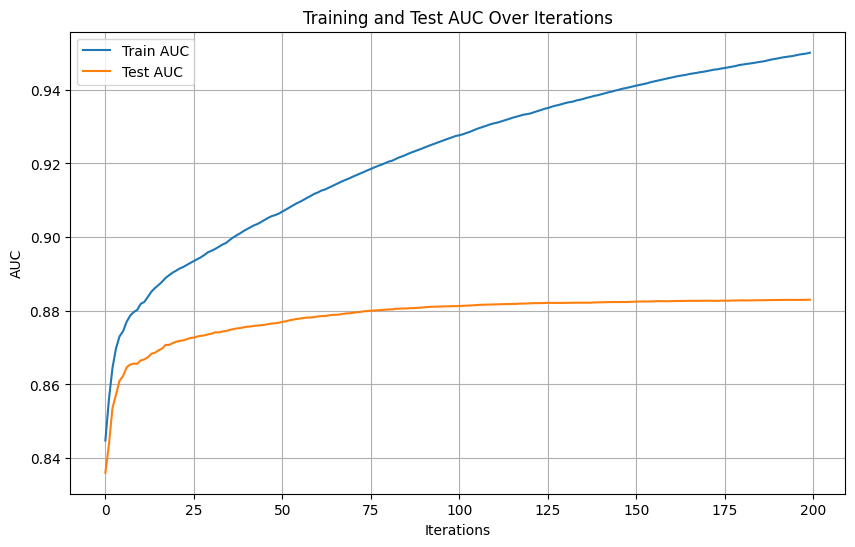

In [178]:
plt.figure(figsize=(10, 6))
plt.plot(train_auc, label='Train AUC')
plt.plot(test_auc, label='Test AUC')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('Training and Test AUC Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

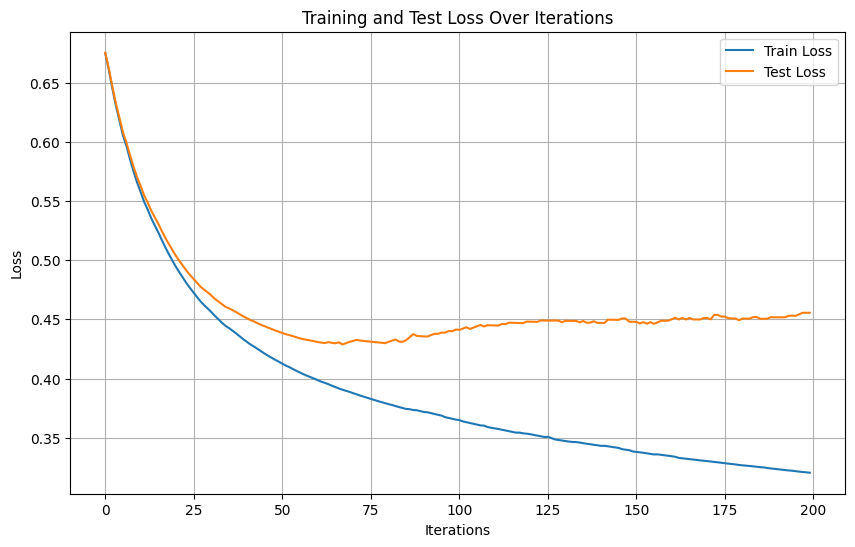

In [179]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Create binary evaluation class

In [194]:
dtest = xgb.DMatrix(X_test)
predictions = best_model.predict(dtest)

In [195]:
from sklearn.metrics import f1_score

In [262]:
f1 = []
highest_f1 = 0
highest_thresh = 0

for threshold in np.arange(0.3, 0.7, 0.01):
    binary_predictions = np.where(predictions >= threshold, 1, 0)

    current_f1 = f1_score(y_test, binary_predictions)
    f1.append(current_f1)

    if current_f1 > highest_f1:
        highest_f1 = current_f1
        highest_thresh = threshold

print(f"Highest F1 Score: {highest_f1:.4f} at Threshold: {highest_thresh:.2f}")

Highest F1 Score: 0.7383 at Threshold: 0.53


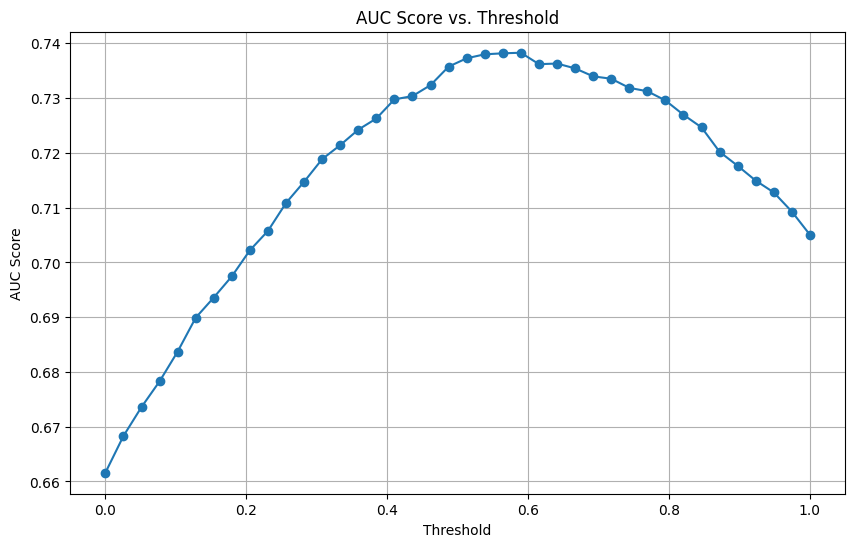

In [268]:
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, len(f1)), f1, marker='o')
plt.xlabel('Threshold')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Threshold')
plt.grid(True)

In [269]:
binary_pred = np.where(predictions >= highest_f1, 1, 0)

In [270]:
xgb_eval = BinaryClassificationEvaluation(y_test, binary_pred, predictions)

In [271]:
print(xgb_eval.classification_report())

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     15296
           1       0.89      0.56      0.69      7226

    accuracy                           0.84     22522
   macro avg       0.86      0.76      0.79     22522
weighted avg       0.84      0.84      0.82     22522



|| ROC AUC Score: 0.88 ||


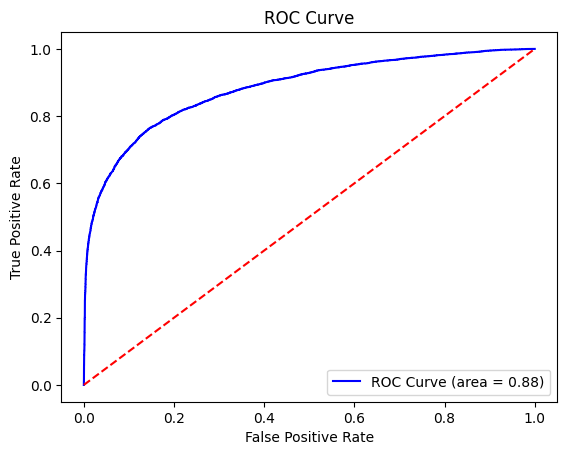

In [272]:
xgb_eval.roc_curve_visualization()

# Save model

In [273]:
class XGBoostModel:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        matrix = xgb.DMatrix(X)
        predictions = self.model.predict(matrix)
        return np.where(predictions >= 0.5, 1, 0)
        return
    def predict_proba(self, X):
        matrix = xgb.DMatrix(X)
        return self.model.predict(matrix)

In [274]:
model = XGBoostModel(best_model)

In [275]:
with open('/content/drive/MyDrive/Churn Prediction/xgboost_churn.pkl', 'wb') as f:
    dill.dump(model, f)